In [48]:
import xarray as xr

from pydantic import BaseModel, constr, field_validator, ValidationInfo, model_validator
from datetime import datetime
from typing import List, Any, Optional

In [49]:
#TODO dynamic fields based on date
#TODO array should be same length
refdes = "CE02SHBP-LJ01D-11-HYDBBA106"
deployment = "1"

In [46]:
class HydCal(BaseModel):
    refdes: constr(min_length=27, max_length=27)
    deployment: str
    asset_id: constr(min_length=17, max_length=17)
    model: str
    sn: int
    cal_date: datetime
    frequencies: List[float]
    sens: List[float] = None
    sens0: List[float] = None
    sens90: List[float] = None
    ds: Any = None

    @model_validator(mode="after")
    def convert_date(self):
        """Convert cal_date to an ISO 8601 string immediately after instantiation."""
        self.cal_date = self.cal_date.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
        return self  # Must return self in a model validator

    @field_validator("sens")
    @classmethod
    def check_lengths(cls, v, info):
        if "frequencies" in info.data and len(v) != len(info.data["frequencies"]):
            raise ValueError("sens and frequencies must be the same length")
        return v

    def make_ndarray(self):
        if sens is not None:
            print("saving only a single sensitivity data var")
            self.ds = xr.Dataset(
            data_vars={
                "sensitivity": (["frequency"], self.sens),
            },
            coords={
                "frequency": self.frequencies,
            },
            attrs={
                "model": self.model,
                "serial number": self.sn,
                "calibration date": self.cal_date,
            }
            )
        elif sens0 is not None and sens90 is not None:
            print("saving both 0 and 90 degree sensitivities")
            self.ds = xr.Dataset(
            data_vars={
                "sensitivity_0": (["frequency"], self.sens0),
                "sensitivity_90": (["frequency"], self.sens90),
            },
            coords={
                "frequency": self.frequencies,
            },
            attrs={
                "model": self.model,
                "serial number": self.sn,
                "calibration date": self.cal_date,
            }
            )
            

    def save_cal(self):
        self.ds.to_netcdf(f"../metadata/cals/{refdes}_{deployment}.nc")

    def save_simplified_cal(self):
        pass
        
    


In [47]:
hyd = HydCal(
    asset_id="ATOSU-58324-00014",
    model="SB35-ETH",
    sn=1270,
    cal_date=datetime(2023,3,1),
    frequencies =[0, 10000, 20100, 30100, 40200, 50200, 60200, 70300, 80300, 90400, 100400, 110400, 120500, 130500, 140500, 150600, 160600, 170700, 180700, 190700, 200000],
    sens=[-168, -168.0, -169.8, -170.2, -169.8, -168.8, -169.6, -169.4, -171.6, -171.0, -169.7, -169.7, -169.8, -168.8, -168.1, -167.8, -165.8, -166.0, -168.4, -169.9, -171.6],
    )

hyd.make_ndarray()

ValidationError: 2 validation errors for HydCal
refdes
  Field required [type=missing, input_value={'asset_id': 'ATOSU-58324...-168.4, -169.9, -171.6]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing
deployment
  Field required [type=missing, input_value={'asset_id': 'ATOSU-58324...-168.4, -169.9, -171.6]}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing

In [33]:
hyd.cal_date

'2023-03-01T00:00:00.000000Z'

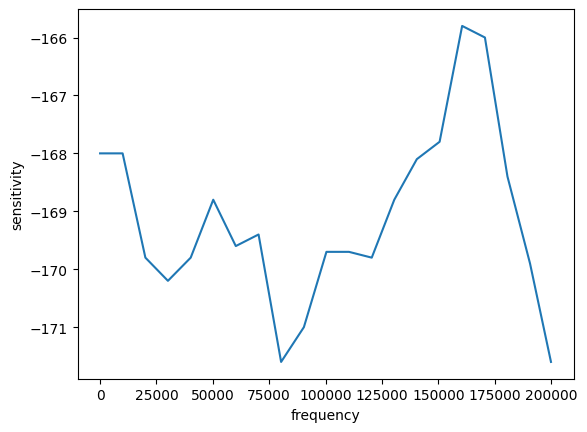

In [34]:
hyd.ds.sensitivity.plot()

In [35]:
hyd.ds.to_netcdf("../metadata/cals/test_cal2.nc")